# Stock Price Prediction Based On Past Prices
## Project Proposal

Project by:  

Asaf Alina  
Alon Gouldman




# Goal

Our goal is to predict stocks' future prices, using historical prices data.  
But not stock prices alone would be interesting to forecast;  
prediction of stock's volatility, or future direction (up/down) - would be interesting, and might yeild profits.


Ideally, we would want to be able to predict stocks's prices, and beat the ultimate benchmark - the market itself.  
That being said, beating the market isnt necessarily an indication of good strategy, as there might be other strategies that beat our strategy.  
Therefore, assuming we do manage to beat the market, we would make a comparison between our model/s, and other models/trading strategies.

# Motivation

The motivation behind being able to predict the prices of the stock market is clear -  
knowing if price of a stock would go up, would allow us as investors to trade the stocks and earn profits.  

This simple goal is, in fact, one of the toughest problems in history.  
Great minds and a lot of money was spilled trying to solve this problem -  
since this ability to forecast prices means a great financial benefit for the one who acquire it.  

The equty market is a zero-sum game - one's gains is another's losses.  
Therefore, market participents has no interest of sharing knowledge,  
as once someone does, the knowledge will be "priced" in the market, and the edge will be lost. 

The dynamic nature of the stock market - the changing correlations and non-linearity -  
make some researches believe in the "randon walk theory" - which state that stock prices move randomly.  
Even if the stock market is not totally random, it is affected by many factors, such as global
economy, politics, investor expectation, etc -  
which make future movements very hard to forecast.


That being said - we try our luck in solving this problem. We believe we have a chance to success, because of these factors: 
1. The data about the stocks is out there - but turns out it is not so easy to put your hands on good quality data after all.  
We had a hard time getting big amount of data (more on that later),  
so we think that when raising the entry barrier up - we face less competitors. 
2. We assume that even if the data looks random - it is not random at all.  
The price of a stock is an aggregated mix of what every investor in the world is pricing that stock in that moment.  
Humans are not so rational - but they do not act randomly.  
And so, it make sense to us that there could be a way to predict the way people will behave.

# Our Data
A simple Google search usually solve most of the problems in life.  
Not in this case though - going through a lot of websites and search results,  
we could not find a good source of data to test our models against.  
The data we were looking for is called "intraday" data -  
we wanted to know everything that happened on every minute in the stock market. 

finding daily data was relativly easy -  
but out goal was to be able to predict the stock market in every minute, and this data was more of a challenge. 

We almost lost hope - but eventually we managed to find two interesting sources of data. 

## IEX stock market data
[IEX website](https://iexcloud.io/) has an almost free API about stocks' prices.  
There is a limit to the number of history we could get - and we could get only partuall data about the stocks.  
But the advantage of this website is that there is data about ~8700 stocks, so it was a great source of data for us. 

### scraping
We build a web scraper with [Scrapy](https://scrapy.org/), in order to get all the stocks data,  
and saving it into different files, based on the stock ticker.  
We managed to get data of around a year back - from the 1/4/19 to the 06/05/2020.  
We got a total of 8,737 stocks, data that weights 35.03 GB:

<br/>
<img src="dir_IEX.jpg" alt="drawing"/>

Lets take a glimpse of our data,  
and look at the data of a single ticker - Apple inc's stock - AAPL:

In [3]:
from pathlib import Path
from typing import Optional
import pandas as pd


def minimal_IEX_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """ get raw IEX-OHLC dataframe, make minimal preprocessing on it and remove redundant columns """

    # make 1 datetime column
    df['datetime'] = df['date'] + "," + df['minute']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d,%H:%M')
    del df['date']
    del df['minute']
    del df['label']

    # sort data by from old datetime to new datetime
    df.sort_values(by=['datetime']).reset_index(drop=True, inplace=True)

    return df


def get_stock_data(ticker: str) -> Optional[pd.DataFrame]:
    optional_file_paths = ['data/relevant/snp500_from_iex', 'data/relevant/iex_data']
    for path in optional_file_paths:
        file_path = Path(path) / f"{ticker}.csv"
        if file_path.exists():
            return pd.read_csv(file_path)
    return None

In [4]:
apple_data = get_stock_data("AAPL")
minimal_IEX_preprocessing(apple_data)
apple_data.head()

,high,low,open,close,average,volume,notional,numberOfTrades,datetime
0,200.385,199.69,200.33,200.320,200.100,20793.0,4160671.710,131.0,2019-04-09 09:30:00
1,200.880,200.33,200.48,200.690,200.643,17520.0,3515273.345,139.0,2019-04-09 09:31:00
2,201.090,200.59,200.72,200.870,200.794,16127.0,3238210.120,114.0,2019-04-09 09:32:00
3,201.030,200.70,200.91,200.990,200.846,6030.0,1211102.170,50.0,2019-04-09 09:33:00
4,201.250,200.97,200.98,201.155,201.095,6060.0,1218639.150,64.0,2019-04-09 09:34:00


This is the data we managed to get for free.  
The prices (open, high, low & close) are clearly importent for us.  
But also maybe the the `number of trades` and `volume` could be usefull. 

This is how the stock prices look like:

In [5]:
import plotly.graph_objects as go


def plot_ohlc_graph_from_dataframe(datafram: pd.DataFrame):
    fig = go.Figure(data=go.Ohlc(x=datafram['datetime'],
                        open=datafram['open'],
                        high=datafram['high'],
                        low=datafram['low'],
                        close=datafram['close']))
    fig.show()



# plot_ohlc_graph_from_dataframe(apple_data)

![alt text](AAPL_candlestick.jpg)

(we used image of the OHLC graph, as its pretty heavy, and its slows down the jupyter notebook)

the second  website we found was a bit more challenging - but also more promising. 
## Ducascopy stock market data
[Ducascopy](https://www.dukascopy.com/swiss/english/home/) is a swiss bank for trading all kinds of equities.  
It has 3 years of minute by minute bid and ask data, including stocks, bonds, commodities, forex and more.  
Downloading their data manually is straight forward, but make it automatically is challanging -  
they dont have a free API for individuals,  
and the network calls made when downloading seem to return an encrypted data.  
Not only that, every so often there is a login pop-up which requires entering email and password to continue downloading.

### Scraping
We used [selenium](https://selenium-python.readthedocs.io/) to imitate a user browsing into Ducascopy website.  
This user imitation has clear disadvantages - it was very slow and prone to unexpected bugs.  
We implimented a "retrieve data" logic to bypass unexpected bugs during downloading.  
To deal with the speed of downloading, we tried to raise some instances of the scraper in parallel.  
This simple step failed, as it seems that Dukascopy website detect such parallel downloads.  
We overcome this issue using Opera web browser, which has a built-in VPN that we manually turned on on each scraper instance.  
In addition, we used multiple accounts when the login window poped up,  
so our downloads will be better disguised (though we were never blocked).

After a couple of nights of running the scraper - we finally had big amount of data we could work with.  
We managed to get bid data of 654 financial instruments, going from 1/1/2017 to 1/5/2020 - a total of 65 GB.  
We still considering downloading the ask data, though the bid should be suffice for now.

<br/>
<img src="dir_dukascopy.jpg" alt="drawing"/>

Before we continue - lets take a look at the same stock - Apple's stock - from this data source: 

In [42]:
def read_dukas(csv_path):
    df = pd.read_csv(csv_path)
    
    # rename columns
    new_cols_map = {col: col.lower() for col in df}
    new_cols_map['Local time'] = "datetime"
    df.rename(columns=new_cols_map, inplace=True)

    # convert datetime type (string to datetime)
    df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    # sort by datetime
    df.sort_values(by=['datetime'], inplace=True)
    
    # reset index, more convenient
    df.reset_index(drop=True, inplace=True)
    
    return df

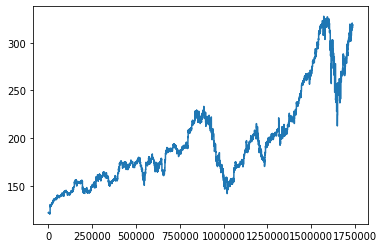

In [43]:
aapl_csv_path = r'data/relevant/dukascopy/BID/AAPL.USUSD.csv'
aapl_df = read_dukas(aapl_csv_path)

aapl_df['close'].plot()

Now that we have seen our data - it's time to try and make some predictions. 

# Attempt #1 - trying to predict the direction of a stock using Random Forests

Our first attemp before we try to predict the price itself - is to try and predict the direction the price is going to. 

Some useful imports before we start:

In [44]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

We will use the data from Ducascopy for now. 


## Data processing 
Lets start with processing the data, cleaning it and adding some features that might be useful.

We first split the datetime of each row (data sample) into its components - minute, hour, day, etc...  
This might be useful if there is seasonality in our data - similar behavior at specific regular intervals of time.  
For example, it is known phenomena that stocks tend to be more volatile at the start of the trading day than in middle of it.  
Catching such behavior, regarding stocks future direction, would be easier if we split the datetime.

In [45]:
def add_times(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """ split datetime column to its components (ie minute, hour, day etc...) """

    df['minute'] = df[col].dt.minute
    df['hour'] = df[col].dt.hour
    df['day'] = df[col].dt.day
    df['month'] = df[col].dt.month
    df['minute_of_day'] = df['minute'] + df['hour'] * 60
    df['day_of_week'] = df['datetime'].dt.dayofweek
    return df

add_times(aapl_df, 'datetime')

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 00:00:00,121.864,121.864,121.864,121.864,0.0,0,0,26,1,0,3
1,2017-01-26 00:01:00,121.864,121.864,121.864,121.864,0.0,1,0,26,1,1,3
2,2017-01-26 00:02:00,121.864,121.864,121.864,121.864,0.0,2,0,26,1,2,3
3,2017-01-26 00:03:00,121.864,121.864,121.864,121.864,0.0,3,0,26,1,3,3
4,2017-01-26 00:04:00,121.864,121.864,121.864,121.864,0.0,4,0,26,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1736755,2020-05-23 23:55:00,318.688,318.688,318.688,318.688,0.0,55,23,23,5,1435,5
1736756,2020-05-23 23:56:00,318.688,318.688,318.688,318.688,0.0,56,23,23,5,1436,5
1736757,2020-05-23 23:57:00,318.688,318.688,318.688,318.688,0.0,57,23,23,5,1437,5
1736758,2020-05-23 23:58:00,318.688,318.688,318.688,318.688,0.0,58,23,23,5,1438,5


Second, we found that Ducascopy fill the gaps between trading days.  
(For example - on suterdays, were the stock market is close, our data is filled with the last close price).  
Lets remove those fills:

In [46]:
# drop inactive hours
mask = (aapl_df['minute_of_day'] >= (16*60+30)) & (aapl_df['minute_of_day'] <= (23*60))
aapl_df = aapl_df[mask]

# drop inactive days
mask = (aapl_df['day_of_week'] != 5) & (aapl_df['day_of_week'] != 6)
aapl_df = aapl_df[mask]

# reset index - more convenient
aapl_df.reset_index(drop=True, inplace=True)
aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,34,16,26,1,994,3


As we can see, there are still inactive data samples (holydays, for example).  
lets see how many 0 volume rows we have:

In [47]:
1 - np.count_nonzero(aapl_df['volume']) / len(aapl_df)

0.05296172615996375

about 5%.  
lets drop every row that has volume 0, except rows that are at 23:00

In [48]:
mask = (aapl_df['volume'] != 0) | (aapl_df['minute_of_day']==23*60)
aapl_df = aapl_df[mask]

aapl_df.reset_index(drop=True, inplace=True)

lets see how many volume 0 now:

In [49]:
1 - np.count_nonzero(aapl_df['volume']) / len(aapl_df)

0.002372220054623453

~0.2%, much better.

In [50]:
aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,34,16,26,1,994,3


### Data aggregation
Another pre-processing action we want to do, is to aggregate the data into bigger chunks.  
Relatively speaking, there is not much of a change in price of a stock, if we look at it minute by minute.  
So instead of having data for every minute - we will have data for every `AGG` (In this example, `AGG == 10`). 

In [51]:
AGG = 10 + 1

aapl_df['high'] = aapl_df['high'].rolling(AGG).max()
aapl_df['low'] = aapl_df['low'].rolling(AGG).min()
aapl_df['open'] = aapl_df['open'].shift(AGG-1)

In [52]:
aapl_df.head(20)

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,NaN,NaN,NaN,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:31:00,NaN,NaN,NaN,121.891,0.3697,31,16,26,1,991,3
2,2017-01-26 16:32:00,NaN,NaN,NaN,122.060,0.4814,32,16,26,1,992,3
3,2017-01-26 16:33:00,NaN,NaN,NaN,122.240,0.6113,33,16,26,1,993,3
4,2017-01-26 16:34:00,NaN,NaN,NaN,122.213,0.6310,34,16,26,1,994,3
5,2017-01-26 16:35:00,NaN,NaN,NaN,122.042,0.5824,35,16,26,1,995,3
6,2017-01-26 16:36:00,NaN,NaN,NaN,122.221,0.5718,36,16,26,1,996,3
7,2017-01-26 16:37:00,NaN,NaN,NaN,122.240,0.4668,37,16,26,1,997,3
8,2017-01-26 16:38:00,NaN,NaN,NaN,122.230,0.5610,38,16,26,1,998,3
9,2017-01-26 16:39:00,NaN,NaN,NaN,122.211,0.4925,39,16,26,1,999,3


Lets drop minutes that are not within aggregation step:

In [53]:
mask = aapl_df['minute'] % (AGG-1) == 0
aapl_df = aapl_df[mask]

# reset index - more convenient
aapl_df.reset_index(drop=True, inplace=True)

aapl_df.head()

,datetime,open,high,low,close,volume,minute,hour,day,month,minute_of_day,day_of_week
0,2017-01-26 16:30:00,NaN,NaN,NaN,121.710,0.4459,30,16,26,1,990,3
1,2017-01-26 16:40:00,121.680,122.430,121.66,122.053,0.4777,40,16,26,1,1000,3
2,2017-01-26 16:50:00,122.221,122.221,121.81,122.090,0.4805,50,16,26,1,1010,3
3,2017-01-26 17:00:00,122.010,122.111,121.93,121.971,0.4826,0,17,26,1,1020,3
4,2017-01-26 17:10:00,122.029,122.112,121.90,122.064,0.3233,10,17,26,1,1030,3


### Adding more features to the data
In order to add some more information to our model, we will add more features to the data. 

The first feature we will add, is the `rate of change` - the percentage-wise change in price from some time to another.  
We will calculate the rate of change (`roc` in short) of the close prices,  for few time intervals: 



1) close roc 1h, 2h, 1d  
2) close std 1h, 2h, 1d  
3) target - direction of next candle

In [54]:
def rate_of_change(df, col, new_col, length):
    df[new_col] = df[col]/df[col].shift(int(length / (AGG-1)))
    
    
for length, new_col in zip([60,120,400], ['roc1h', 'roc2h', 'roc1d']):
    rate_of_change(aapl_df, 'close', new_col, length)  

next, we will calculate and add `standard deviation` for some time intervals: 

In [55]:
def standard_deviation(df, col, new_col, length):
    df[new_col] = df[col].rolling(int(length / (AGG-1))).std()
      

for length, new_col in zip([60,120,400], ['std1h', 'std2h', 'std1d']):
    standard_deviation(aapl_df, 'close', new_col, length)

Last, we will label our data:  
if the price in the future (next data sample) will go up - we will label it as `1`.  
If the price goes down - we will label it as `-1`:

In [56]:
aapl_df['target'] = aapl_df['close'].shift(-1) / aapl_df['close'] - 1
aapl_df['target'][aapl_df['target'] > 0] = 1
aapl_df['target'][aapl_df['target'] <= 0] = -1

In [57]:
aapl_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
datetime,2017-01-26 16:30:00,2017-01-26 16:40:00,2017-01-26 16:50:00,2017-01-26 17:00:00,2017-01-26 17:10:00,2017-01-26 17:20:00,2017-01-26 17:30:00,2017-01-26 17:40:00,2017-01-26 17:50:00,2017-01-26 18:00:00,2017-01-26 18:10:00,2017-01-26 18:20:00,2017-01-26 18:30:00,2017-01-26 18:40:00,2017-01-26 18:50:00,2017-01-26 19:00:00,2017-01-26 19:10:00,2017-01-26 19:20:00,2017-01-26 19:30:00,2017-01-26 19:40:00
open,NaN,121.68,122.221,122.01,122.029,122.044,121.919,121.7,121.84,121.85,121.821,121.69,121.7,121.713,121.77,121.91,121.822,122,121.804,121.792
high,NaN,122.43,122.221,122.111,122.112,122.114,121.932,121.852,121.893,121.903,121.883,121.758,121.773,121.844,121.922,121.91,122.002,122,121.861,121.882
low,NaN,121.66,121.81,121.93,121.9,121.85,121.64,121.68,121.712,121.77,121.6,121.62,121.62,121.67,121.76,121.8,121.64,121.79,121.78,121.77
close,121.71,122.053,122.09,121.971,122.064,121.862,121.74,121.84,121.862,121.854,121.69,121.659,121.71,121.801,121.851,121.82,121.903,121.82,121.833,121.88
volume,0.4459,0.4777,0.4805,0.4826,0.3233,0.3929,0.3124,0.3755,0.3247,0.4993,0.3525,0.4433,0.3552,0.3642,0.42,0.3173,0.4814,0.2939,0.2705,0.309
minute,30,40,50,0,10,20,30,40,50,0,10,20,30,40,50,0,10,20,30,40
hour,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19
day,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
month,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Normalization
We want to squeeze our data into the range of 0-1.  
Now, this is tricky - if we do regular normalization, we actually use the entire range of data to check the values for normalization.  
This way, we interduce "Lookahead Bias" into out data - we will normalize knowing what the future data will be.  

In order to prevent that, we will normalize our data with a rolling window -  
every point in time will be normalized according to the past 10 data samples - of 10 minutes each - and so we will prevent the Bias. 

In [58]:
def norm_window(df, length):
    return (df - df.rolling(length).min()) / (df.rolling(length).max() - df.rolling(length).min())


for col in ['open','high','low','close']:
    aapl_df[col] = norm_window(aapl_df[col], 10)

finally, drop Nans

In [59]:
aapl_df.dropna(inplace=True)
aapl_df.reset_index(drop=True, inplace=True)

In [60]:
aapl_df.head().T

,0,1,2,3,4
datetime,2017-01-27 16:30:00,2017-01-27 16:40:00,2017-01-27 16:50:00,2017-01-27 17:00:00,2017-01-27 17:10:00
open,0.0983607,1,1,0.422535,1
high,1,1,0.588235,0.705882,0.829412
low,0,0.5,0,1,1
close,0.642857,1,0.84,1,0.464396
volume,0.4466,0.6504,0.5663,0.3583,0.448
minute,30,40,50,0,10
hour,16,16,16,17,17
day,27,27,27,27,27
month,1,1,1,1,1


## Modeling

The first model we will try is a Random Forest model.  
We will try to find hyperparameters that will do well on AAPL's data. 
  
In order to do that, lets first split the dataset into training, validation and test sets.  
we will split the data in a simple (maybe stupid) way -  
the training set will be from 26/1/2017 - 1/3/2019,  
the validation set will be from 1/3/2019 - 1/10/2019,  
and the test set will be from 1/10/2019 - 22/5/2020.  

We will further investigate the way we split our dataset in the future, but that will do for now.

In [61]:
def split_data(df, date1, date2=None):
    """ split the data into training set and test set. 
        if the date2 argument is passed, split the data into training, validation, and test sets.
        dates are string formats, in the format 'mm-dd-yyyy'.
        split will be made on the 'datetime' column (assuming passed df has one)
    """
    
    if date2==None:
        train = df[df['datetime'] < date1]
        test = df[df['datetime'] >= date1]
        return train, test
    else:
        train = df[df['datetime'] < date1]
        valid = df[(df['datetime'] >= date1) & (df['datetime'] < date2)]
        test = df[df['datetime'] >= date2]
        return train, valid, test

    
train, valid, test = split_data(aapl_df, "03-01-2019", "10-01-2019")
for df in [train, valid, test]:
    df.drop(columns='datetime', inplace=True)

Setup basic RF model:

In [ ]:
rf1 = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth=20, random_state=1)
rf1.fit(train.drop(columns=['target']), train['target'])

In [63]:
def pred_acc(target, pred):
    """prediction accuracy"""
    return (np.sign(pred) == target).sum() / len(pred)


def print_score(target, pred):
    print(f"Mean squared error = {mean_squared_error(target, pred)}")
    print(f"Accuracy = {pred_acc(target, pred)}")
    

print_score(valid['target'], rf1.predict(valid.drop(columns='target')))

Mean squared error = 1.0329357014951037
Accuracy = 0.5039508340649693


Terrible results on the validation set (like coin flip).  
How well is it on training set?

In [64]:
print_score(train['target'], rf1.predict(train.drop(columns='target')))

Mean squared error = 0.3497170365814462
Accuracy = 0.9960982658959537


We have an overfit!  

Lets change our hyperparameters:  
we redeuce the maximum depth of each tree in our forest, so it will have harder time overffiting.

In [ ]:
rf1 = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth=10, random_state=1)
rf1.fit(train.drop(columns=['target']), train['target'])

In [66]:
print_score(valid['target'], rf1.predict(valid.drop(columns='target')))

Mean squared error = 1.0098525525692055
Accuracy = 0.5046532045654083


Still bad. still overfit?

In [67]:
print_score(train['target'], rf1.predict(train.drop(columns='target')))

Mean squared error = 0.8498289248708008
Accuracy = 0.7913294797687861


Not as much, but still overfit we believe (79% accuracy is probably just too good to be true).

Lets try to automate the hyperparameters tunning.  
Lets run many RFs, with different, randomly selected hyperparameters,  
and then we will figure out if we found some interesting RF.

In [68]:
random.seed(1)
rfs = []
hps = []
scores = []

for i in range(300):
    
    # generate hyper parameters
    hp = {'max_depth': random.choice([5,7,10,15]),
          'min_samples_leaf': random.choice([3,5,10,20]), 
          "max_features": random.choice([0.3,0.5,0.7,1]), 
          'bootstrap': random.choice([True, False]),
          'oob_score': random.choice([True, False]),
          'n_estimators': random.choice([10,30,50,100]),
          'n_jobs': -1, 
          'random_state': 1}
    
    # create RF (if created HP doesnt have conflict)
    try:
        rf = RandomForestRegressor(**hp)
        rf.fit(train.drop(columns=['target']), train['target'])
    except:
        pass
    else:
        score_d = dict()
        
        # calc score on validation set
        pred = rf.predict(valid.drop(columns='target'))
        score_d['v_MSE'] = mean_squared_error(valid['target'], pred)
        score_d['v_acc'] = pred_acc(valid['target'], pred)

        # calc score on training set
        pred = rf.predict(train.drop(columns='target'))
        score_d['t_MSE'] = mean_squared_error(train['target'], pred)
        score_d['t_acc'] = pred_acc(train['target'], pred)

        # save data and RFs
        rfs.append(rf)
        hps.append(pd.DataFrame(hp, index=[0]))
        scores.append(pd.DataFrame(score_d, index=[0]))    

In [69]:
results = pd.concat([pd.concat(hps), pd.concat(scores)], axis=1).reset_index(drop=True)
results = results.drop_duplicates()
results.head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
0,7,3,0.7,True,False,100,-1,1,1.002133,0.512204,0.952899,0.654335
1,15,20,0.5,True,False,10,-1,1,1.017249,0.509219,0.841676,0.739306
2,15,20,0.3,False,False,30,-1,1,1.011542,0.500615,0.804004,0.856021
3,5,10,0.3,True,True,10,-1,1,1.002216,0.511853,0.984759,0.556792
4,15,5,1.0,True,True,100,-1,1,1.002305,0.510799,0.781930,0.940944


How many RFs were created?

In [70]:
len(results)

193

Any good RF with good results on validation set?

In [71]:
results.sort_values(by=['v_acc'], ascending=False).head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
8,5,5,1.0,False,False,10,-1,1,0.999927,0.521686,0.990247,0.557081
81,15,5,1.0,False,False,100,-1,1,1.000901,0.519754,0.727742,0.969316
57,15,20,1.0,True,False,100,-1,1,1.000502,0.519052,0.905847,0.793738
170,5,10,0.5,True,True,10,-1,1,1.000904,0.518525,0.983114,0.561657
38,15,10,0.7,True,True,50,-1,1,1.009944,0.516945,0.775186,0.893690


52%!  
Ok! little better...  

how good the results are in terms of our loss function?

In [38]:
results.sort_values(by=['v_MSE'], ascending=True).head()

,max_depth,min_samples_leaf,max_features,bootstrap,oob_score,n_estimators,n_jobs,random_state,v_MSE,v_acc,t_MSE,t_acc
201,7,20,1.0,True,True,50,-1,1,0.998829,0.515364,0.978643,0.614306
160,7,20,1.0,True,False,50,-1,1,0.998829,0.515364,0.978643,0.614306
89,7,10,1.0,True,False,100,-1,1,0.999015,0.514838,0.975331,0.623940
65,5,3,1.0,False,False,50,-1,1,0.999061,0.512379,0.989336,0.570809
74,5,5,1.0,True,False,100,-1,1,0.999083,0.509219,0.989194,0.574855


Still very bad. Naive model which yield 0 on each prediction will have MSE of 1.  
So the results are not amazing. 

How decisive are our models?  
Could it be that predictions that are closer to 1/-1 has higher accuracy?  
Maybe predictions that are closer to 0 indicate uncertainty in the prediction?  

lets try to find an answer in the data:  
1) Lets take the predicitons of our best 10 RFs.  
2) Put close predictions into baskets (rounding the predictions).  
3) See wether the further the basket of predictions from 0, the better accuracy we get.

Take the predictions of our 10 best RFs:

In [72]:
rfs_idx = list(results.sort_values(by=['v_acc'], ascending=False).head(10).index)
pred = []
target = []
for i in rfs_idx:
    pred.append(rfs[i].predict(valid.drop(columns='target')))
    target.append(valid['target'])

# merge the predictions and targets
pred = np.concatenate(pred)
target = np.concatenate(target)

Let see the predictions values range:

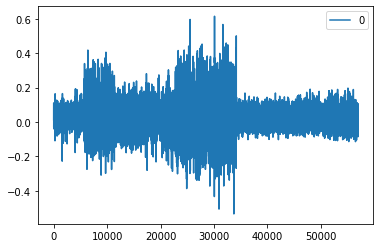

In [73]:
pd.DataFrame(pred).plot()

Interesting...  
we can see that predictions ranges differently across different RFs.  

Alright, we can (and should) further examine that, but for now we will leave that aside.  

Coming back to our previoues question,  
lets see (in our __best RF only__) if the distance of predictions from 0 is an indication of prediction's accuracy.

Taking best RF predictions

In [75]:
best_i = results.sort_values(by=['v_acc'], ascending=False).index[0]
best_rf = rfs[best_i]
pred = best_rf.predict(valid.drop(columns=['target']))

Predictions range:

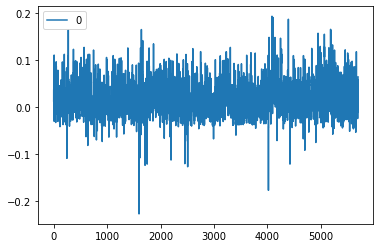

In [76]:
pd.DataFrame(pred).plot()

We can see some skew towards the positive values.  
This might come from the natural tendency of stocks (and aaple in particular) to rise over long perionds of time,  
yet this is just a speculation.

Rounding predictions:

In [78]:
pred[pred>0] = np.ceil(pred[pred>0]*100)/100
pred[pred<=0] = np.floor(pred[pred<=0]*100)/100

Accuarcy levels per basket of predictions:

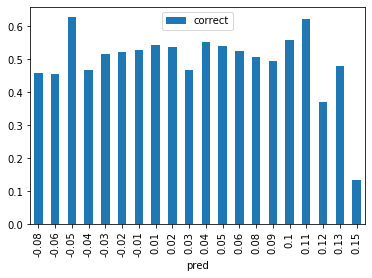

In [79]:
df = pd.DataFrame([pred, valid['target']]).T
df.columns = ['pred', 'target']

# calculate how many correct predictions
df['correct'] = np.sign(df['pred']) == np.sign(df['target'])

del df['target']

# calculate accuracy
c = df.groupby(['pred']).count()
s = df.groupby(['pred']).sum()
acc = s/c

# display baskets with at least 10 predictions in it
acc = acc[c > 10].dropna()

# plotting
acc.rename(columns={'correct':'acc'})
acc.plot.bar()

Our intuition doesnt seem to hold true in the predictions of our best RF.  

Some next steps we consider on predicting stock's future price direction:
1. Check, on multiple Random Forests, if the further the prediction from 0, the better the accuracy.  
We want to be able to understand from the model, how certain the model is about his prediction. 
2. Try different loss functions - ones which punish more heavily on predictions that are close to 0.  
We want our model to be decisive - this might be one way to get it.
3. Add more features.
4. Extract features importance from the model.
5. Testing this model on more stocks, not just Apple.  
Maybe a general model will predict better for each individual stock.

# Where do we go from here

### Trying more models
Our first attempt wasn't great.  
Next, we want to try different models. We will try to use MLP reguilar neural network.  
Another interesting model architecture which we have read about, is called LSTM (Long Short Term Memory) Network.  
It should work good on time series data - so we could use this here. 

Another model that we would like to try is called ARIMA - Auto Regressive Integrated Moving Average.  
This model also should work well for time series, so we want to give it a try. 

### Adding more data
We currantly only tested our models against Apple inc.'s data.  
We would like to test the model when we feed data about more stocks. 

Also, if we reach a point where we are "stuck" - we might try to add more data from other sources.  
But not only stock data - we can compare tweets about stocks, news paper's data, etc. 


### Challenges ahead
There are two main chalenges we see coming: 
1. We have a lot of data - and we are limited in computetion power.  
We might reach the limits of our private CPU's power, and this can hold us back.
2. If the stock's prices alone can't tell us about what the future is holding -  
we will have to be creative and gather data from other sources. 
